##  Классификация изображений (датасет CIFAR 10)

#### Загрузка датасета с нормализацией

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # нормализация на [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# training dataset - 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# вспомогательная функция для отображения изображения
def imshow(img):
    # денормализация
    img = img / 2 + 0.5
    # преобразовать из тензорного изображения и показать
    plt.imshow(np.transpose(img, (1,2,0)))

Посмотрим на изображения:

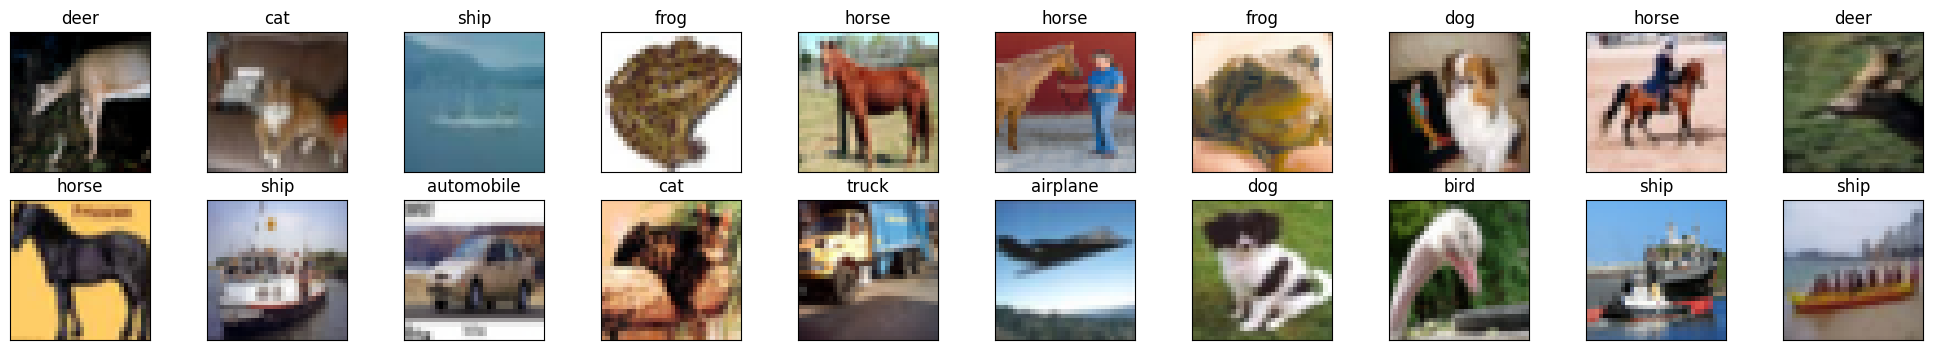

In [ ]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

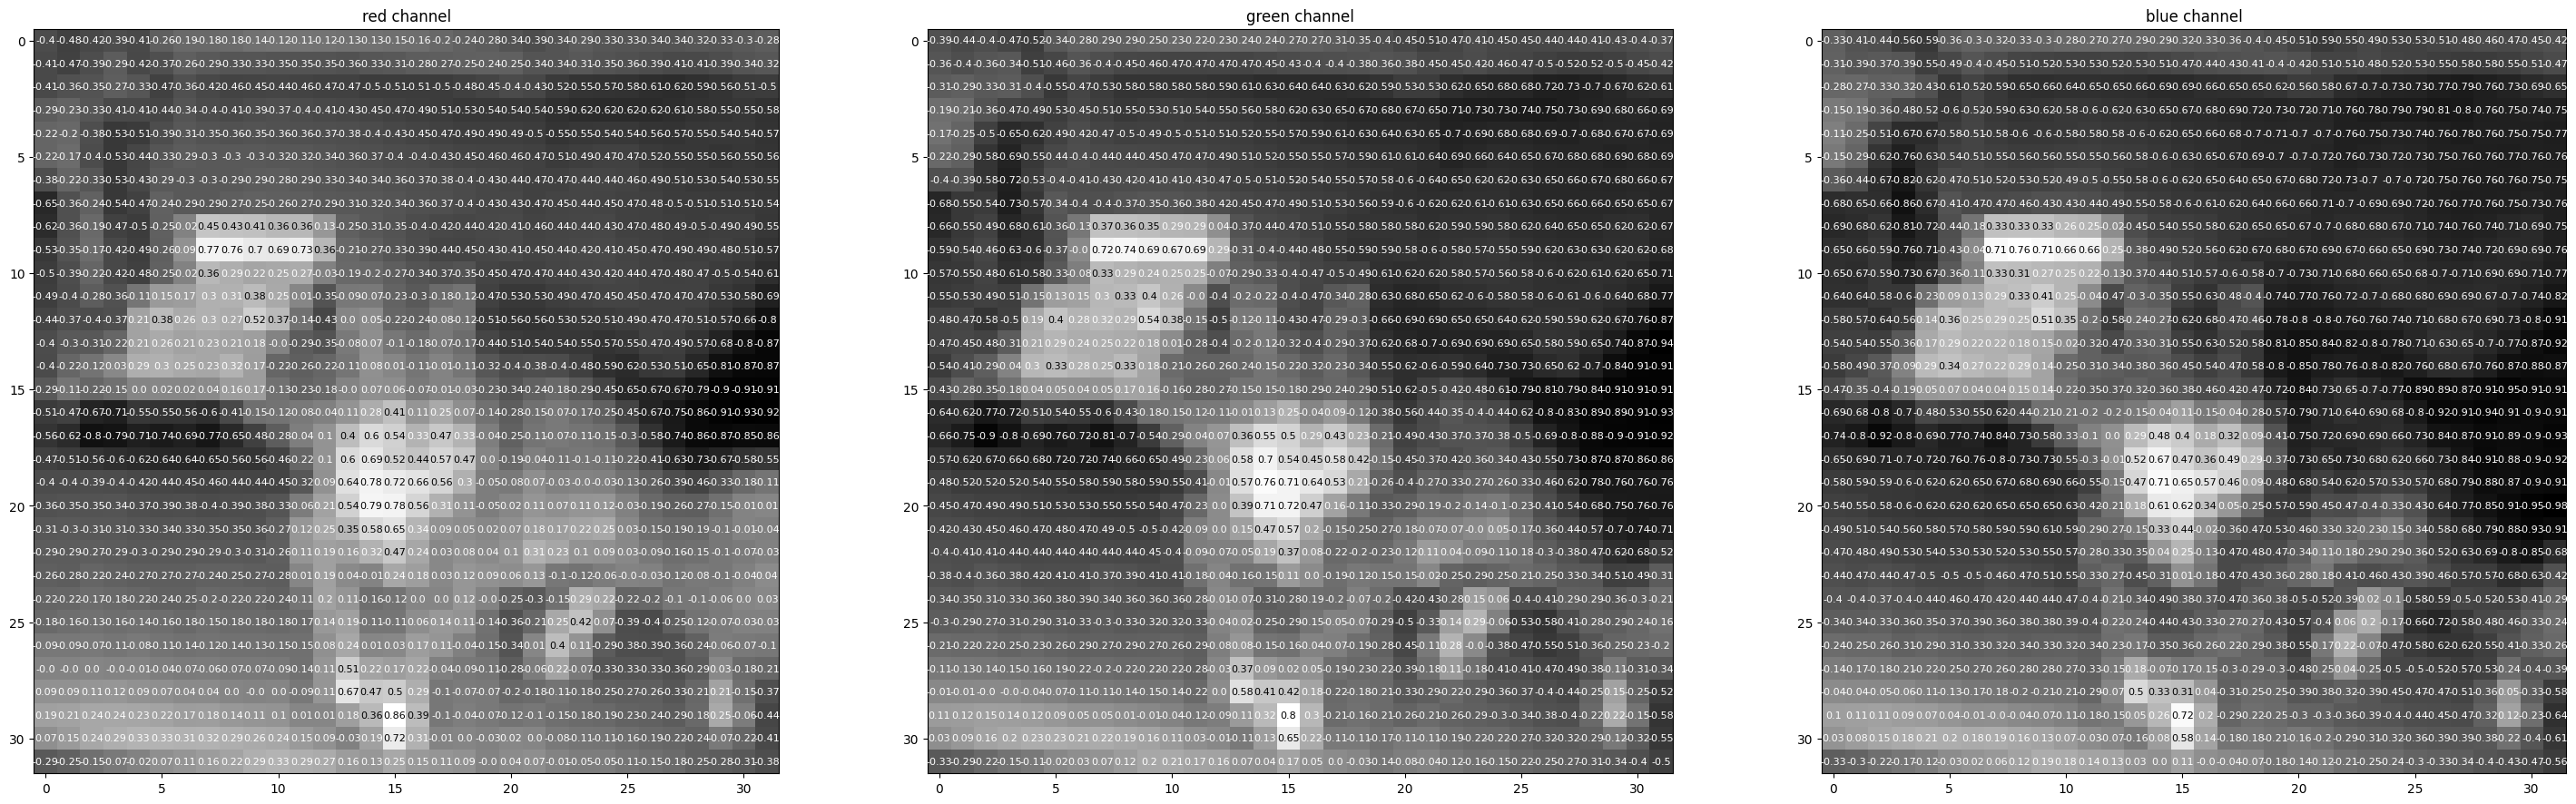

In [ ]:
rgb_img = np.squeeze(images[1])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

####  Архитектура модели для решения задачи

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # Первый сверточный слой
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Первый сверточный + пулинг
        x = self.pool(F.relu(self.conv2(x)))  # Второй сверточный + пулинг
        x = x.view(-1, 64 * 8 * 8)           # Преобразование в плоский вид
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Обучение модели

In [ ]:
model = CIFAR10_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество параметров в модели: {count_parameters(model)}")

Количество параметров в модели: 2250954


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
import seaborn as sns

train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0

        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train / len(train_loader)
        epoch_loss_val = epoch_loss_val / len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    # Return метрики
    #return train_losses, val_losses, train_labels, train_preds, val_labels, val_preds

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Train Loss: 1.3949, Val Loss: 1.1004,
 Train Acc: 49.32%, Val Acc: 60.80%,
 Train F1: 0.49, Val F1: 0.60,
 Train MAE: 1.8467, Val MAE: 1.4164, Time: 106.94s




Epoch [2/5], Train Loss: 0.9693, Val Loss: 0.9575,
 Train Acc: 65.53%, Val Acc: 66.67%,
 Train F1: 0.57, Val F1: 0.63,
 Train MAE: 1.5301, Val MAE: 1.2988, Time: 118.48s




Epoch [3/5], Train Loss: 0.7659, Val Loss: 0.8841,
 Train Acc: 72.77%, Val Acc: 69.66%,
 Train F1: 0.62, Val F1: 0.65,
 Train MAE: 1.3346, Val MAE: 1.2077, Time: 118.38s




Epoch [4/5], Train Loss: 0.5910, Val Loss: 0.8703,
 Train Acc: 79.17%, Val Acc: 70.32%,
 Train F1: 0.67, Val F1: 0.67,
 Train MAE: 1.1762, Val MAE: 1.1502, Time: 117.98s




Epoch [5/5], Train Loss: 0.4241, Val Loss: 0.9522,
 Train Acc: 85.17%, Val Acc: 70.76%,
 Train F1: 0.70, Val F1: 0.67,
 Train MAE: 1.0392, Val MAE: 1.1161, Time: 116.58s




#### График функции потерь по эпохам

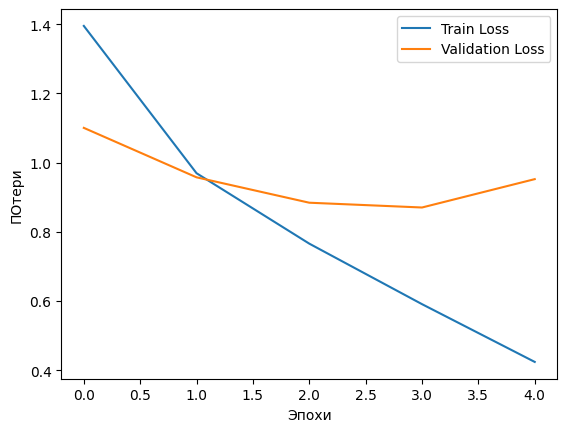

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('ПОтери')
plt.show()

#### Матрица ошибок и значение accuracy на тестовом множестве

Матрица ошибок:
[[727  18  79  24  17  13  12  17  50  43]
 [ 17 791  19  14   1   5   8   3  17 125]
 [ 37   2 627  72  55  76  75  37   6  13]
 [ 22   7  66 483  41 229  78  33  12  29]
 [ 16   2 128  80 543  68  92  60   6   5]
 [ 14   6  43 141  23 678  29  53   6   7]
 [  4   3  39  45  26  35 831   5   4   8]
 [ 11   6  35  33  36  85   7 769   0  18]
 [ 79  43  20  18   4  10  10   4 769  43]
 [ 34  64   7  12   3  11   8  20  11 830]]

Accuracy на тестовом множестве: 70.48 %
Test F1 Score: 0.7043
Test MAE: 1.0086



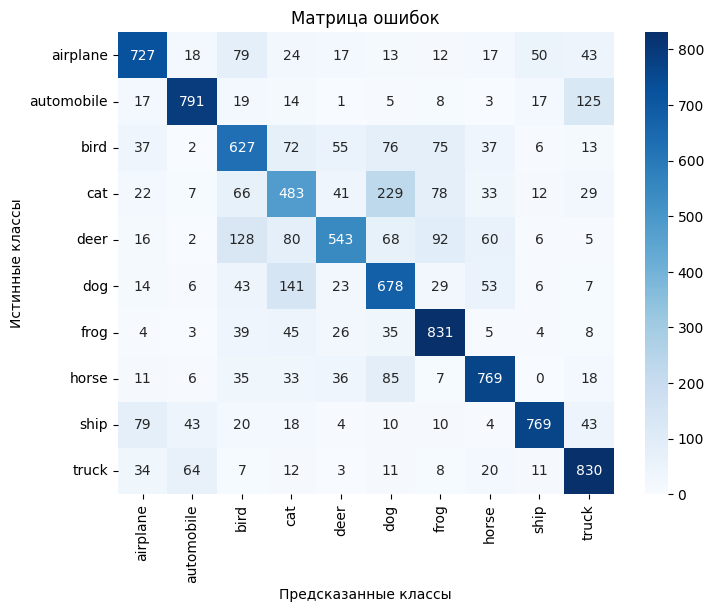

In [ ]:
from sklearn.metrics import accuracy_score

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            y_pred = model(images)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = test_model(model, test_loader)

# Оценка модели на тестовых данных
accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
mae = mean_absolute_error(true_labels, predictions)

print('Матрица ошибок:')
print(conf_matrix)

print(f'\nAccuracy на тестовом множестве: {100*accuracy:.2f} %')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test MAE: {mae:.4f}\n')


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

#### Демонстрация работы модели: выводим несколько изображений, правильный класс и класс, предсказанный моделью

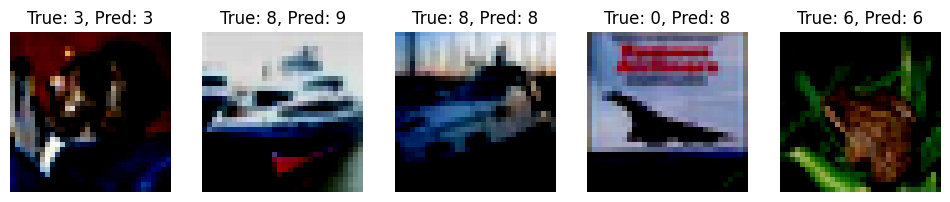

In [ ]:
def plot_sample_images(test_loader, predictions, true_labels, num_images=5):
    test_images, _ = next(iter(test_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

    for i in range(num_images):
        axes[i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))
        axes[i].set_title(f"True: {true_labels[i]}, Pred: {predictions[i]}")
        axes[i].axis('off')

plot_sample_images(test_loader, predictions, true_labels)

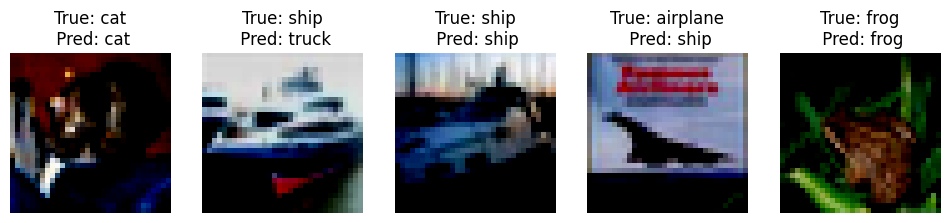

In [ ]:
def plot_sample_images(test_loader, predictions, true_labels, classes, num_images=5):
    test_images, _ = next(iter(test_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

    for i in range(num_images):
        axes[i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))  # транспон для прав графика
        predicted_class = classes[predictions[i]]
        true_class = classes[true_labels[i]]
        axes[i].set_title(f"True: {true_class}\n Pred: {predicted_class}")
        axes[i].axis('off')

plot_sample_images(test_loader, predictions, true_labels, classes)

Смотрим на работу первого сверточного слоя:

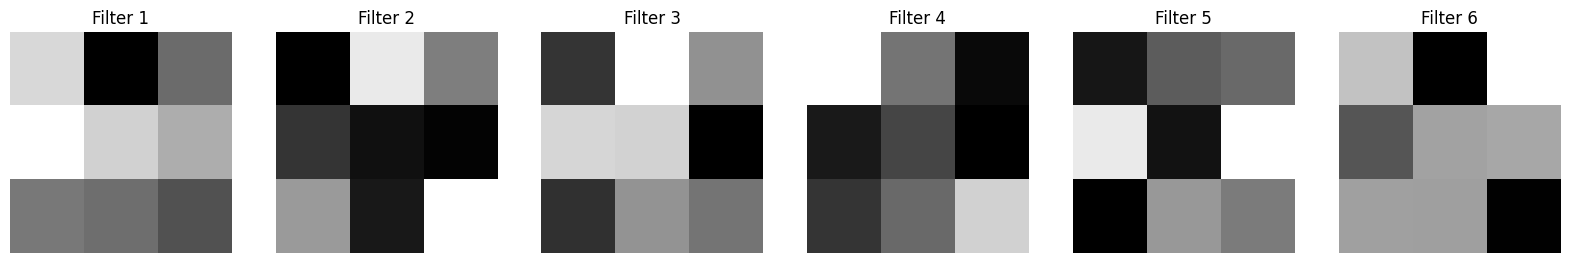

In [ ]:
def visualize_first_layer(model, num_filters=6):
    with torch.no_grad():
        filters = model.conv1.weight.data.cpu().numpy()
        fig, axes = plt.subplots(1, num_filters, figsize=(20, 20))
        for i in range(num_filters):
            axes[i].imshow(filters[i, 0, :, :], cmap='gray')
            axes[i].set_title(f'Filter {i+1}')
            axes[i].axis('off')
    plt.show()

visualize_first_layer(model)

#### Сохранение модели

In [ ]:
torch.save(model.state_dict(), 'cifar10_cnn_model.pth')
print("Saved PyTorch Model State to cifar10_cnn_model.pth")

Saved PyTorch Model State to cifar10_cnn_model.pth


In [ ]:
cifar_model = CIFAR10_CNN()
cifar_model.load_state_dict(torch.load('cifar10_cnn_model.pth'))

<ipython-input-65-17217ba09fd5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cifar_model.load_state_dict(torch.load('cifar10_cnn_model.pth'))


<All keys matched successfully>